# Label the individual spikes

In the previous notebook we started with a raw 2.5Gb scan and produced 5 different individual voxel-based TIFFs of less than 5Mb each. 

Due to time and energy constraints, the spikes were scanned in batches of four rather than individually. Spikes were placed on a color coded foam tray as seen in the picture below. We also kept a log of which spike went into which batch and which color. However, colors are not visible with X-rays, so we must deduce the color based on the location of the tray. Before going into analysis, we must be able to link the individual spikes to the available metadata.

<img src="https://www.egr.msu.edu/~amezqui3/barley/figs/scan_foam.jpg" width=400>

Different trays were scanned with different initial positions, so we cannot rely on a fixed position strategy. We thus have to locate first the wood marker (a block letter M or D) and based on the marker location deduce the color location.

We make the assumption that the wood marker is the smallest connected component. This assumption proved to be true for all scans except one (`S032.tif`).

The general strategy is as follows:
- Identify the marker location
- Identify the bottom (base) of the four spikes
- The red-labelled barley corresponds to the closest base to the marker.
- Identify the rest of the colors green -> orange -> blue by moving clockwise through the bases, starting from red.

**NOTE: We assume that we have 5 connected components in total (4 spikes and a wood marker).** A similar but manual procedure was followed for a handful of scans were this was not the case.

In [2]:
import tifffile as tf
import scipy.ndimage as ndimage
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import os
import argparse
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import importlib

# All the image preprocessing functions are found in `barley_brew`

- The `barley_brew` module is simply a repository of _ad hoc_ image processing functions to clean X-ray CT scans
- The module is not meant to be directly used outside the barley project, but rather provide some inspiration of what can be done to address basic X-ray CT cleaning woes.
- Hence, this notebook attempts to flesh out the functions in the module so other readers might be inspired to try similar tricks on their own.

In [3]:
import demeter.barley_brew as brew

## Load connected components

Notice that in the `src` directory there are files
```
S017_l0_x16_y367_z176.tif   S017_l2_x722_y1052_z0.tif  S017_l4_x48_y0_z86.tif
S017_l1_x717_y352_z148.tif  S017_l3_x0_y1066_z129.tif
```

- Each connected component was assigned a numerical label `l`, starting from 0. 
- Labels are assigned based on number of voxels.
    - `S017_l0_*` is the largest connected component
    - `S017_l1_*` is the second largest connected component
    - And so on
    
- Load a dictionary with the five connected components
    - `img`: dicionary with the actual scans `{filename: TIFF as numpy.array}`
    - `boxes`: dictionary with metadata `{filename: tuple of metadata (x,y,z,w,h,d,l)}`
        - `x,y,z`: coordinates of the bottom,left,front corner of the box containing the connected component with respect to the coordinates of the original scan.
        - `w,h,d`: width, height, depth of the box containing the connected component
        - `l`: label
    - `marker`: name of the file with largest label (the smallest connected component is assumed to be the marker)

In [4]:
src = '../preproc/comps/example/'
img, boxes, marker = brew.read_boxes(src)
bname = marker.split('_')[0]
print('Base name: ', bname)
boxes

NameError: name 'glob' is not defined

## Find the location of the marker and the holes

- Location of the holes can be tricky since some of the spikes are slanted and bent all over the place. 
- Rather than looking at the center of the whole connected component, we look at the center of the bottom 10 slices of the component, which we assume would be mostly just the base of the stems.


- `centers` contain the (x,y) coordinates of these centers
- `dcenters` is a dictionary `{filename: [x,y] }` with the centers coordinates as well.


Compute we also draw the square (convex hull) defined by the holes location
- `scipy.spatial.ConvexHull` defines the convex hull vertices in a clockwise order

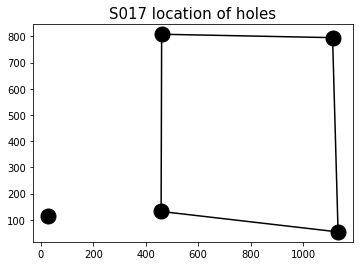

In [22]:
centers,dcenters = brew.find_centers(img, boxes, slices=10)
plt.plot(centers[:, 0], centers[:, 1], c='k', marker='o', lw=0, markersize=15)

hull = ConvexHull(centers[:-1,:])
for simplex in hull.simplices:
    plt.plot(centers[simplex, 0], centers[simplex, 1], 'k-')

plt.title(bname + ' location of holes', fontsize=15)
plt.axis('scaled');

## Find the red hole

- We compute the Euclidean distance from each hole to the marker.
- Return a dictionary `{filename: scalar distance}`
- The red hole corresponds to the one closest to the marker, which in this case corresponds to the `l0` component.

In [26]:
euclidean = brew.euclidean_dists(dcenters, marker)
euclidean

{'S017_l0_x16_y367_z176.tif': 433.2955111699174,
 'S017_l1_x717_y352_z148.tif': 817.3671145819362,
 'S017_l2_x722_y1052_z0.tif': 1281.6434761664416,
 'S017_l3_x0_y1066_z129.tif': 1109.7333012936035}

- Once the red hole is identified, simply move in a clockwise fashion with the convex hull and assign green -> orange -> blue respectively.
- Add the marker color as `black`.

In [28]:
colors = brew.coloring_spikes(dcenters, euclidean, hull)
colors[marker] = 'Black'
colors

{'S017_l0_x16_y367_z176.tif': 'Red',
 'S017_l3_x0_y1066_z129.tif': 'Green',
 'S017_l2_x722_y1052_z0.tif': 'Orange',
 'S017_l1_x717_y352_z148.tif': 'Blue',
 'S017_l4_x48_y0_z86.tif': 'Black'}

## Verify the results

- We can render and save an image in the `dst` directory to assess if the holes were identified as expected.
- The boxes dimensions are according to the actual connected component box size.

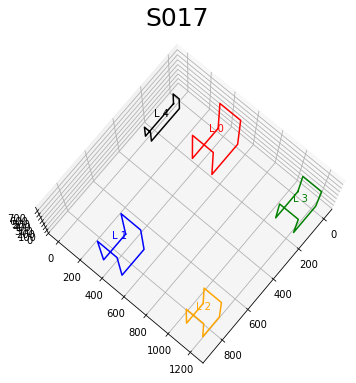

In [40]:
dst = src
brew.render_alignment(dst, bname, boxes, colors, write_fig=False)

## Rename the TIFF files

- Once we've correctly identified the colors, we can add them to the TIFF filenames for future reference.

In [43]:
braces = '{}_'
for fname in colors:
    splt = fname.split('_')
    cname = braces*len(splt) + '{}'
    cname = cname.format(bname,splt[1],colors[fname],*(splt[2:]))
    os.rename(src + fname, src + cname)

barley_files = sorted(glob.glob(src + '*.tif'))
barley_files

['../preproc/comps/example/S017_l0_Red_x16_y367_z176.tif',
 '../preproc/comps/example/S017_l1_Blue_x717_y352_z148.tif',
 '../preproc/comps/example/S017_l2_Orange_x722_y1052_z0.tif',
 '../preproc/comps/example/S017_l3_Green_x0_y1066_z129.tif',
 '../preproc/comps/example/S017_l4_Black_x48_y0_z86.tif']